# Block Analysis

In [2]:
import os
from pprint import pprint

import dask.dataframe as dd
import networkx as nx
from matplotlib import pyplot as plt
from web3 import Web3

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

2025-02-18 15:19:00.328 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [3]:
ALCHEMY_API_URL = os.getenv("ALCHEMY_API_URL")
web3 = Web3(Web3.HTTPProvider(ALCHEMY_API_URL))

In [4]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [5]:
dd_arbs = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_logs.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
    converters={"logs": parse_logs},
)

In [6]:
dd_arbs["logs"] = dd_arbs["logs"].apply(parse_logs, meta=("logs", "object"))

In [7]:
dd_arbs["label"] = 1

In [8]:
df = dd_arbs.compute()

In [11]:
len(df["account_address"].unique())

279

In [67]:
dd_normal = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)
dd_normal["receipt"] = dd_normal["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_normal["logs"] = dd_normal["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [68]:
dd_normal["label"] = 0

In [69]:
max_block_nr_norm = dd_normal["block_number"].max().compute()

In [70]:
dd_arbs = dd_arbs[dd_arbs["block_number"] <= max_block_nr_norm]

In [117]:
dd_normal_full_block = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts_full_block.csv"
)
dd_normal_full_block["receipt"] = dd_normal_full_block["receipt"].apply(
    parse_logs, meta=("logs", "object")
)
dd_normal_full_block["logs"] = dd_normal_full_block["receipt"].apply(
    lambda x: x["logs"], meta=("logs", "object")
)

In [118]:
dd_normal_full_block["label"] = 0

In [119]:
max_block_nr_norm_full_block = dd_normal_full_block["block_number"].max().compute()

In [123]:
dd_arbs_full_block = dd_arbs[dd_arbs["block_number"] <= max_block_nr_norm_full_block]

In [71]:
# dd_arbs.head()

In [72]:
# dd_normal.head()

In [124]:
ddf_full_block = dd.concat([dd_arbs_full_block, dd_normal_full_block])

In [73]:
ddf = dd.concat([dd_arbs, dd_normal])

In [74]:
# ddf.head()

In [88]:
def extract_transfer_addresses(log):
    topics = log["topics"]
    ERC20_TRANSFER_SIG = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    if topics[0] != ERC20_TRANSFER_SIG:
        return None, None
    if len(topics) < 3:
        return None, None
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address


def build_graph_for_block(df_block):
    G = nx.MultiDiGraph()

    for _, row in df_block.iterrows():
        logs = row["logs"]
        if not logs:
            continue
        for log in logs:
            from_addr, to_addr = extract_transfer_addresses(log)
            if from_addr is None or to_addr is None:
                continue

            if log["data"] == "0x":
                value = 0
            else:
                value = int(log["data"], 16)

            G.add_node(from_addr, address=from_addr)
            G.add_node(to_addr, address=to_addr)
            G.add_edge(
                from_addr,
                to_addr,
                value=value,
                log_index=log["logIndex"],
                tx_hash=log["transactionHash"],
                topics=log["topics"],
                transaction_index=log["transactionIndex"],
                label=row["label"],
            )

    return G


def build_graphs_per_block(df):
    graphs = {}
    for block, group in df.groupby("block_number"):
        G = build_graph_for_block(group)
        graphs[block] = G
    return graphs

In [125]:
df_full_block = ddf_full_block.compute()

In [76]:
df = ddf.compute()
df = df[df["block_number"] < 16950689]

In [126]:
graphs_full_block = build_graphs_per_block(df_full_block)

In [89]:
graphs = build_graphs_per_block(df)
print(graphs)

{16950601: <networkx.classes.multidigraph.MultiDiGraph object at 0x358e6c560>, 16950602: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d92cbc0>, 16950607: <networkx.classes.multidigraph.MultiDiGraph object at 0x358e6f800>, 16950616: <networkx.classes.multidigraph.MultiDiGraph object at 0x358e6edb0>, 16950619: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d096d80>, 16950628: <networkx.classes.multidigraph.MultiDiGraph object at 0x358e6d2e0>, 16950635: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d097fb0>, 16950638: <networkx.classes.multidigraph.MultiDiGraph object at 0x358e6c2c0>, 16950647: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d097080>, 16950660: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d097710>, 16950665: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d096870>, 16950673: <networkx.classes.multidigraph.MultiDiGraph object at 0x39d095f10>, 16950680: <networkx.classes.multidigraph.MultiDiGraph object at

In [114]:
def plot_graph(G, block):
    plt.figure()
    plt.title(f"Block {block}")
    pos = nx.spring_layout(G, seed=42)

    mev_nodes = set()
    for u, v, key, data in G.edges(keys=True, data=True):
        if data.get("label") == 1:  # assuming label 1 indicates MEV
            mev_nodes.add(u)
            mev_nodes.add(v)

    # Create a color list: blue for MEV nodes, red otherwise
    node_colors = ["red" if node in mev_nodes else "blue" for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50)
    # nx.draw_networkx_labels(G, pos, font_size=6, font_color="black")
    for u, v, key, data in G.edges(keys=True, data=True):
        if G.has_edge(v, u):
            rad = 0.2 if key % 2 == 0 else -0.2
        else:
            rad = 0.0
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            arrowstyle="-|>",
            arrowsize=10,
            connectionstyle=f"arc3, rad={rad}",
        )
    plt.tight_layout()
    plt.show()

## Graphs for individual blocks with subsampled class 0 transactions (5%)

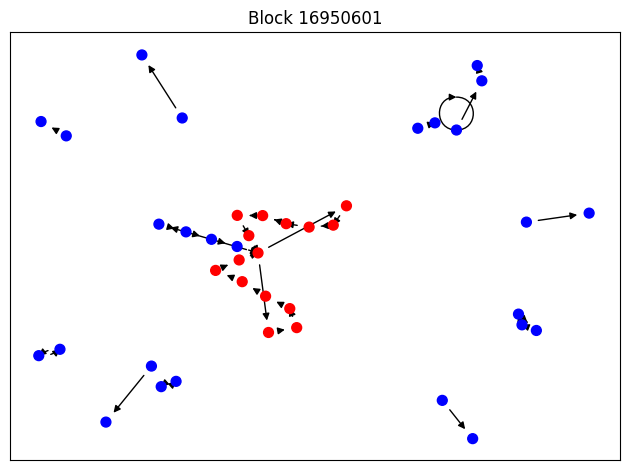

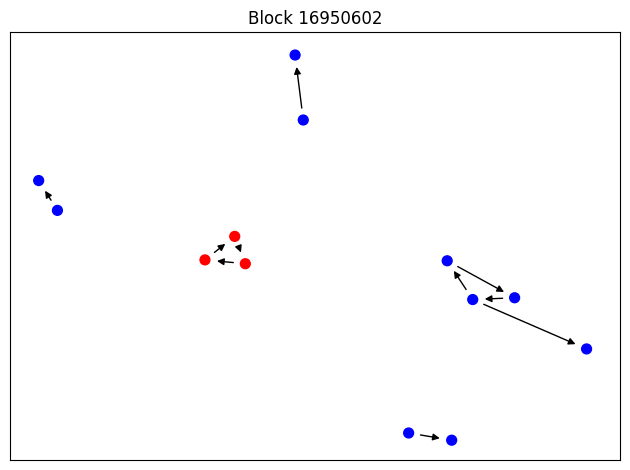

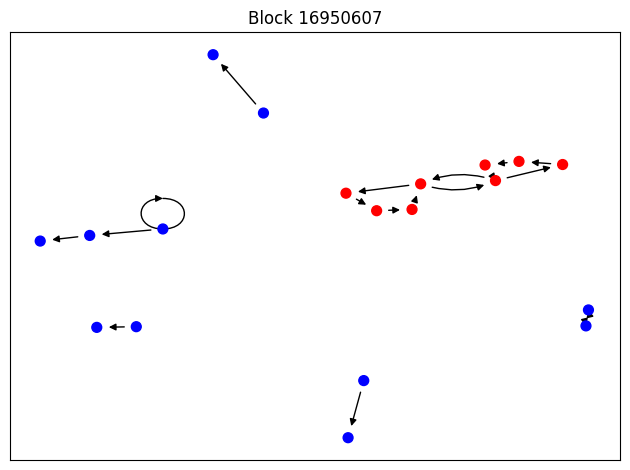

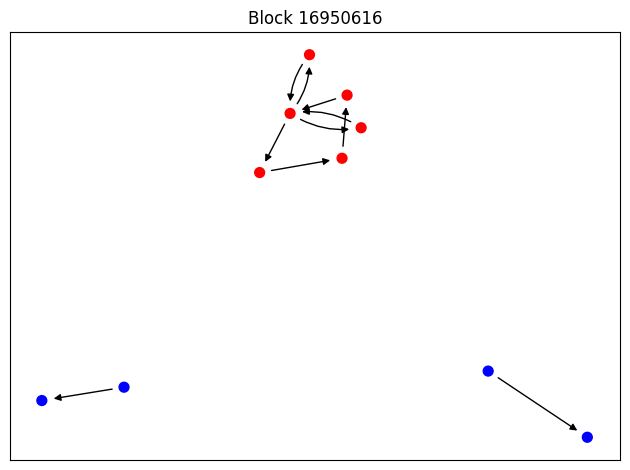

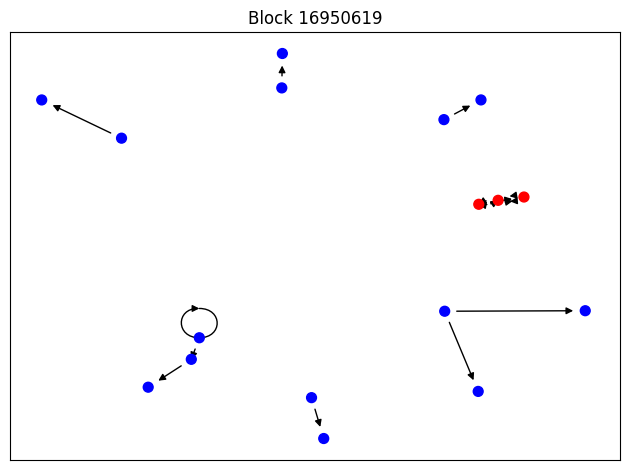

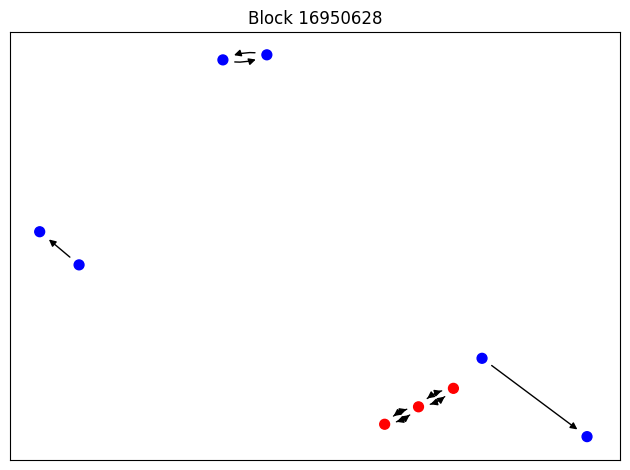

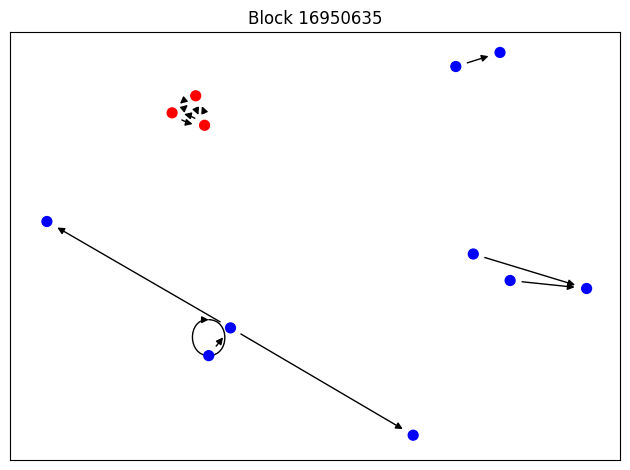

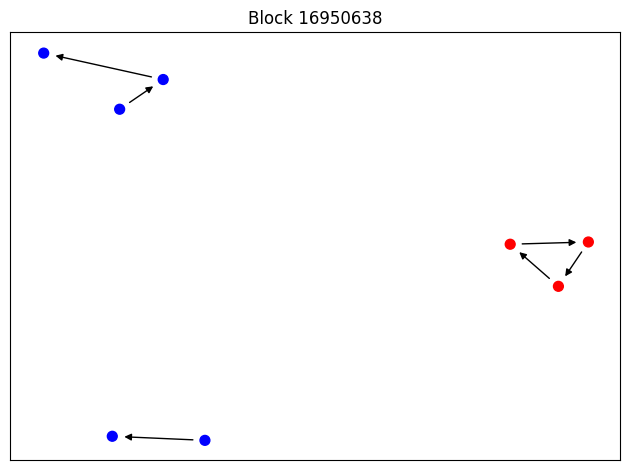

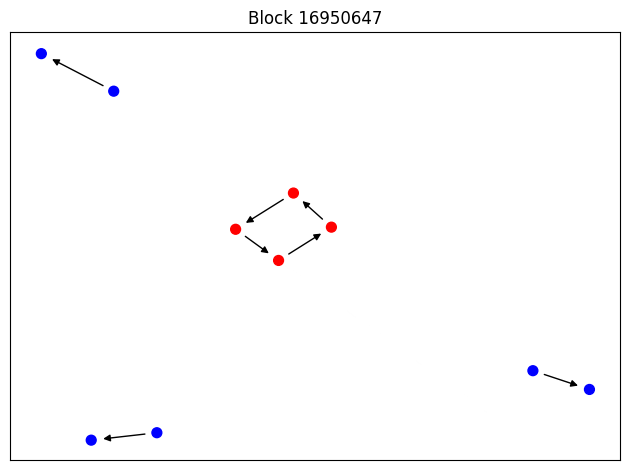

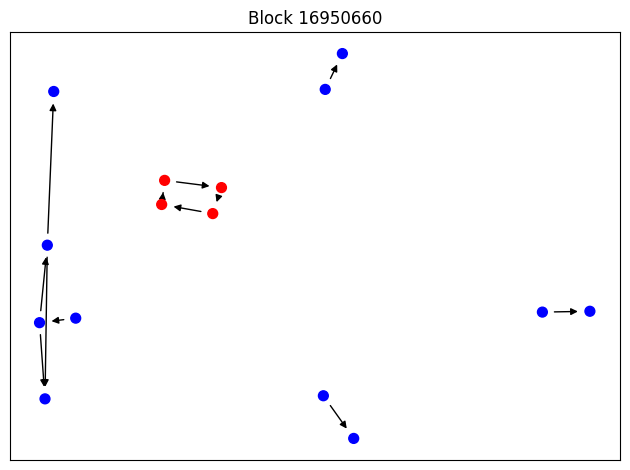

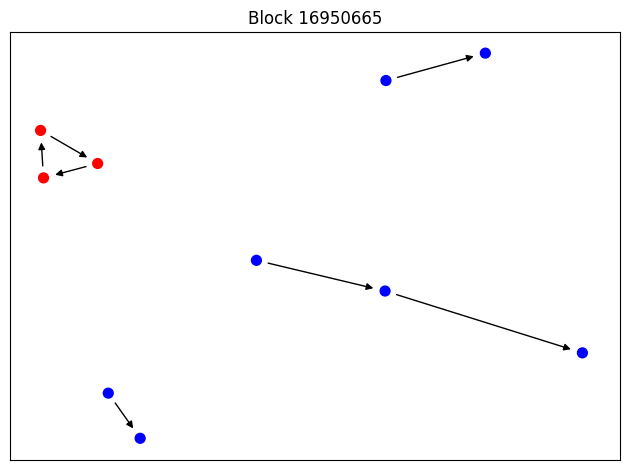

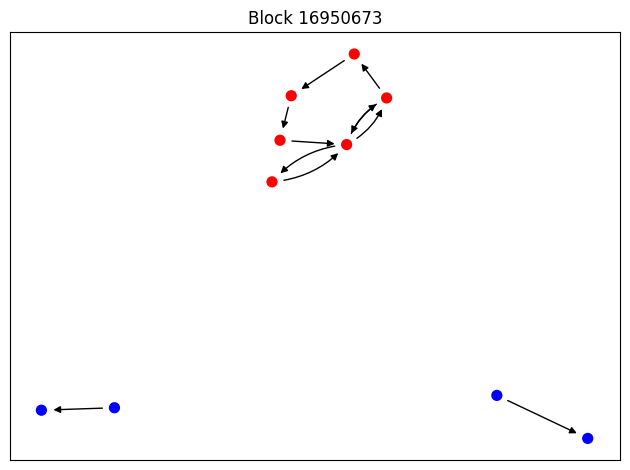

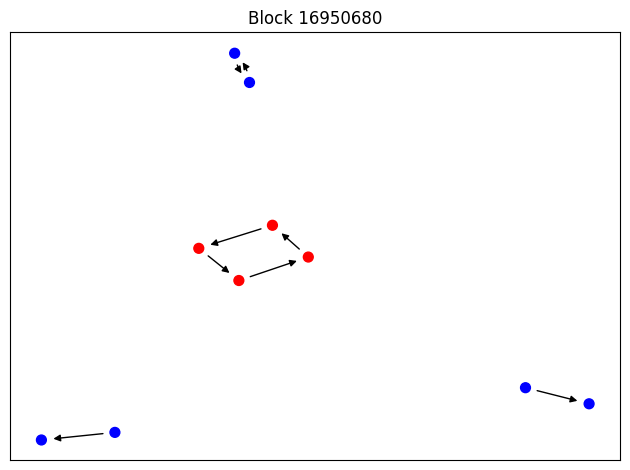

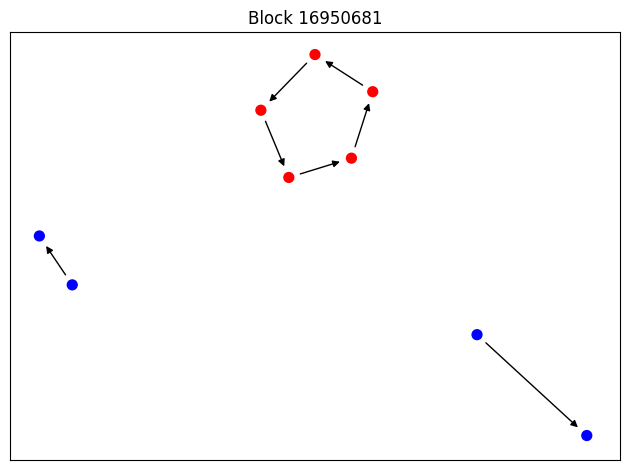

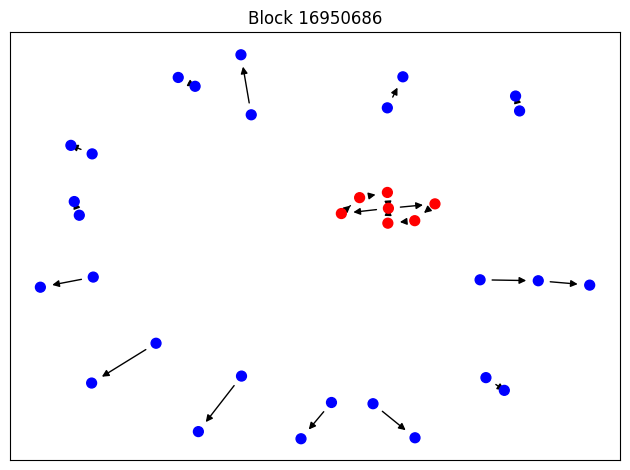

In [115]:
for block, G in graphs.items():
    plot_graph(G, block)

## Graphs for individual blocks with full block class 0 transactions

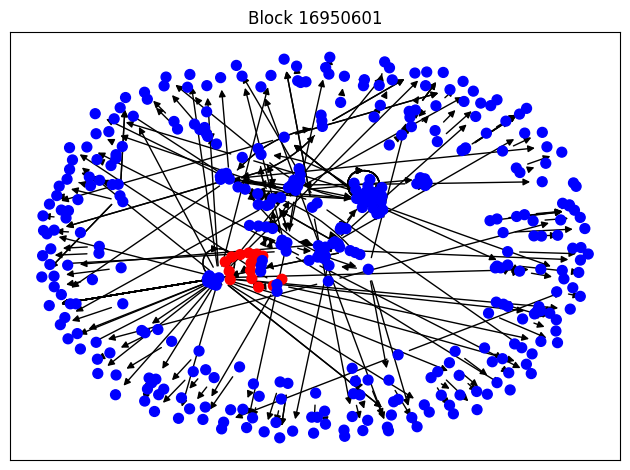

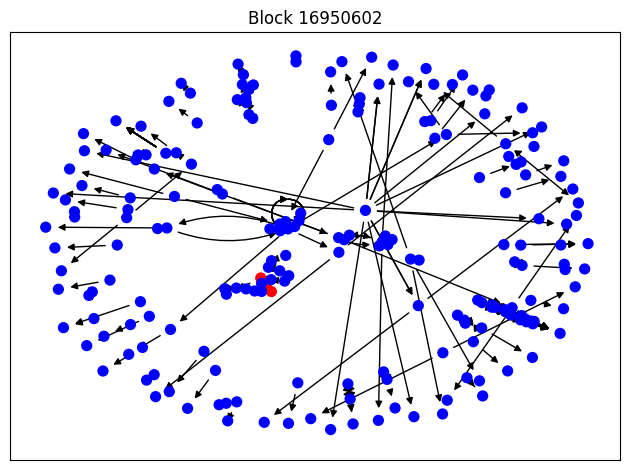

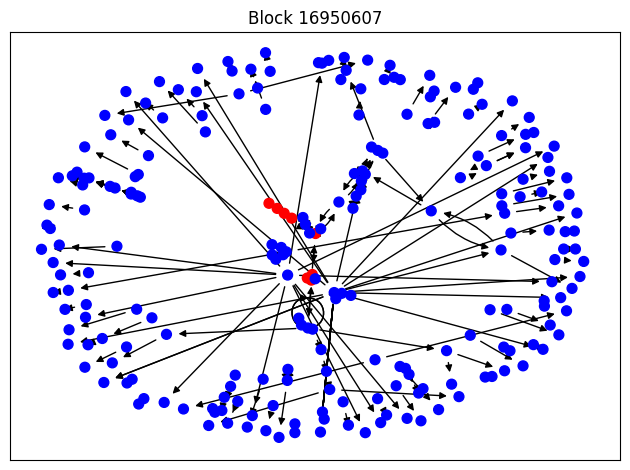

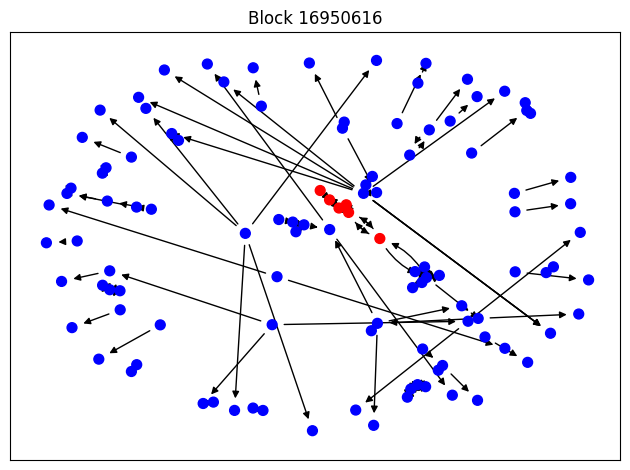

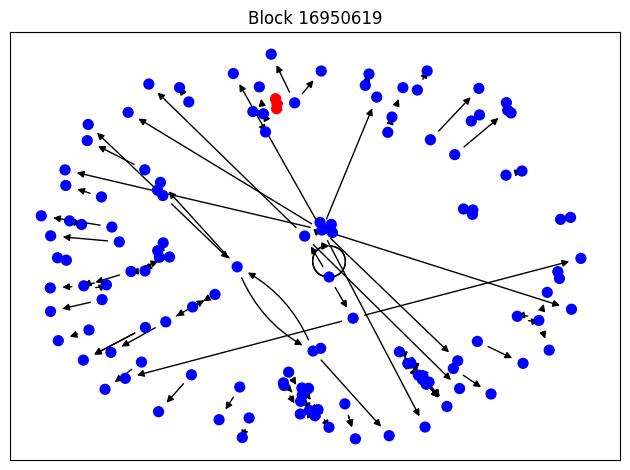

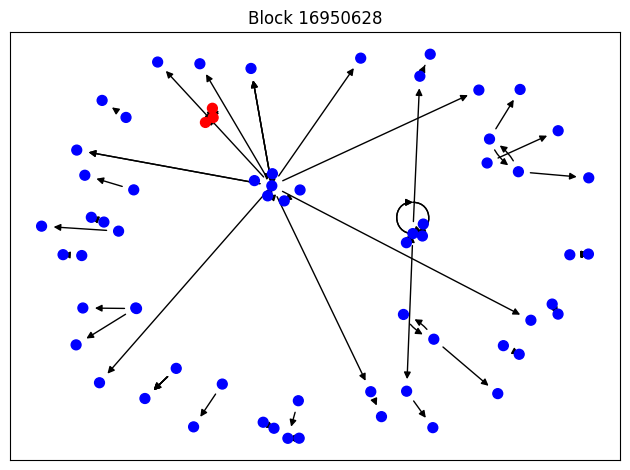

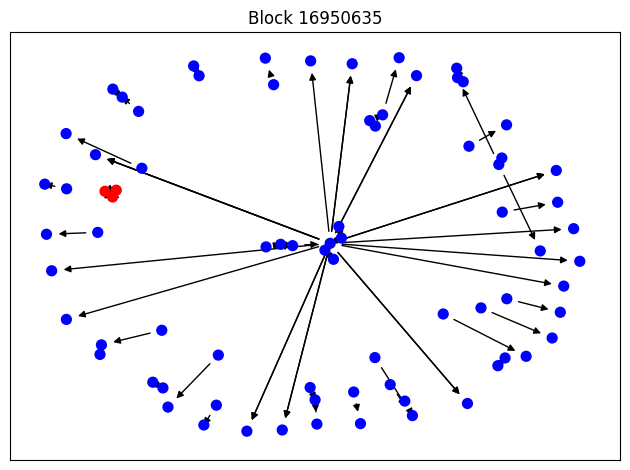

In [127]:
for block, G in graphs_full_block.items():
    plot_graph(G, block)

In [95]:
def compute_graph_metrics(G):
    # Convert to a simple directed graph (merging multiple edges)
    simple_G = nx.DiGraph(G)

    # Graph Density: E / [N*(N-1)]
    density = nx.density(simple_G)

    # Average Degree: sum of all degrees divided by number of nodes
    avg_degree = (
        sum(dict(simple_G.degree()).values()) / simple_G.number_of_nodes()
        if simple_G.number_of_nodes() > 0
        else 0
    )

    # Clustering Coefficient: convert to undirected for clustering calculation
    clustering_coeff = nx.average_clustering(simple_G.to_undirected())

    # Component Analysis: use weakly connected components for directed graphs
    components = list(nx.weakly_connected_components(simple_G))
    largest_component_size = max((len(c) for c in components), default=0)
    num_isolated_nodes = len(list(nx.isolates(simple_G)))

    # Degree Distribution: frequency count of node degrees
    degree_distribution = {}
    for node, degree in simple_G.degree():
        degree_distribution[degree] = degree_distribution.get(degree, 0) + 1

    return {
        "density": density,
        "average_degree": avg_degree,
        "clustering_coefficient": clustering_coeff,
        "largest_component_size": largest_component_size,
        "num_isolated_nodes": num_isolated_nodes,
        "degree_distribution": degree_distribution,
    }

In [101]:
for block, G in graphs.items():
    metrics = compute_graph_metrics(G)
    pprint(metrics)

{'average_degree': 1.8048780487804879,
 'clustering_coefficient': 0.07317073170731707,
 'degree_distribution': {1: 13, 2: 26, 3: 1, 6: 1},
 'density': 0.022560975609756097,
 'largest_component_size': 19,
 'num_isolated_nodes': 0}
{'average_degree': 1.5384615384615385,
 'clustering_coefficient': 0.41025641025641024,
 'degree_distribution': {1: 7, 2: 5, 3: 1},
 'density': 0.0641025641025641,
 'largest_component_size': 4,
 'num_isolated_nodes': 0}
{'average_degree': 1.894736842105263,
 'clustering_coefficient': 0.0,
 'degree_distribution': {1: 7, 2: 9, 3: 1, 4: 2},
 'density': 0.05263157894736842,
 'largest_component_size': 8,
 'num_isolated_nodes': 0}
{'average_degree': 2.0,
 'clustering_coefficient': 0.0,
 'degree_distribution': {1: 4, 2: 5, 6: 1},
 'density': 0.1111111111111111,
 'largest_component_size': 6,
 'num_isolated_nodes': 0}
{'average_degree': 1.6470588235294117,
 'clustering_coefficient': 0.17647058823529413,
 'degree_distribution': {1: 11, 2: 2, 3: 3, 4: 1},
 'density': 0.05

In [128]:
# Example usage:
for block, G in graphs_full_block.items():
    metrics = compute_graph_metrics(G)
    pprint(metrics)

{'average_degree': 1.8931297709923665,
 'clustering_coefficient': 0.06251212293799678,
 'degree_distribution': {1: 244,
                         2: 102,
                         3: 14,
                         4: 9,
                         5: 6,
                         6: 7,
                         7: 1,
                         8: 3,
                         9: 2,
                         10: 1,
                         11: 1,
                         17: 1,
                         22: 1,
                         37: 1},
 'density': 0.0024147063405514876,
 'largest_component_size': 129,
 'num_isolated_nodes': 0}
{'average_degree': 2.0861244019138754,
 'clustering_coefficient': 0.02025518341307815,
 'degree_distribution': {1: 115,
                         2: 50,
                         3: 27,
                         4: 8,
                         6: 4,
                         10: 1,
                         11: 1,
                         12: 1,
                         17: 1,
 

## Dynamic Graphs

In [102]:
def build_graph_for_window(df_window):
    G = nx.MultiDiGraph()
    for _, row in df_window.iterrows():
        logs = row["logs"]
        if not logs:
            continue
        for log in logs:
            from_addr, to_addr = extract_transfer_addresses(log)
            if from_addr is None or to_addr is None:
                continue

            value = 0 if log["data"] == "0x" else int(log["data"], 16)
            # Use address strings directly as node IDs
            G.add_node(from_addr, address=from_addr)
            G.add_node(to_addr, address=to_addr)
            G.add_edge(
                from_addr,
                to_addr,
                value=value,
                log_index=log["logIndex"],
                tx_hash=log["transactionHash"],
                topics=log["topics"],
                transaction_index=log["transactionIndex"],
                label=row["label"],
            )
    return G


def build_dynamic_graphs(df, window_size=10, step_size=1):
    blocks = sorted(df["block_number"].unique())
    dynamic_graphs = {}
    for i in range(0, len(blocks) - window_size + 1, step_size):
        window_blocks = blocks[i : i + window_size]
        df_window = df[df["block_number"].isin(window_blocks)]
        G = build_graph_for_window(df_window)
        # Use the last block number in the window as the key (or any representative timestamp)
        dynamic_graphs[window_blocks[-1]] = (G, window_blocks)
    return dynamic_graphs

In [103]:
dynamic_graphs = build_dynamic_graphs(df, window_size=10, step_size=1)

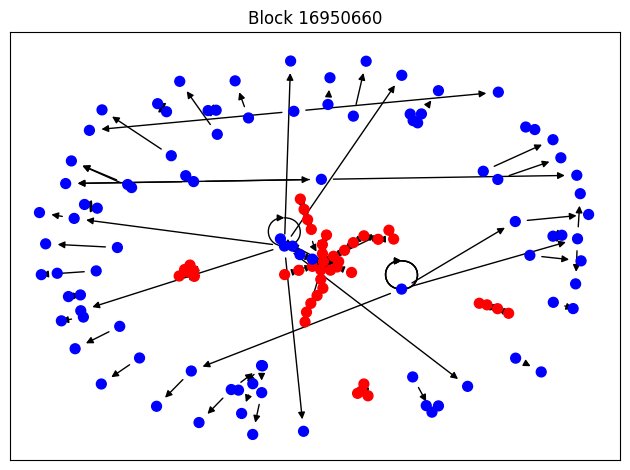

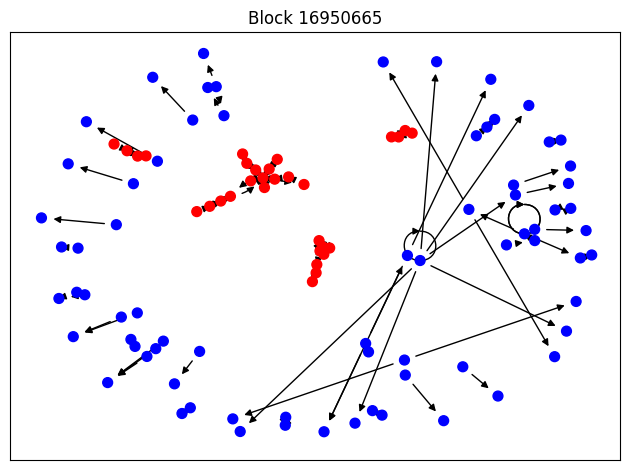

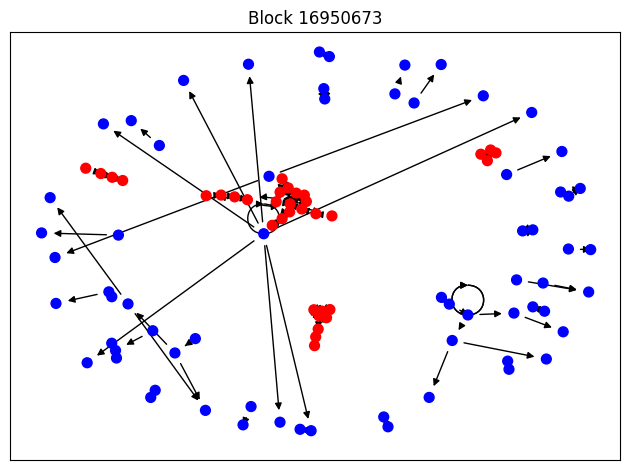

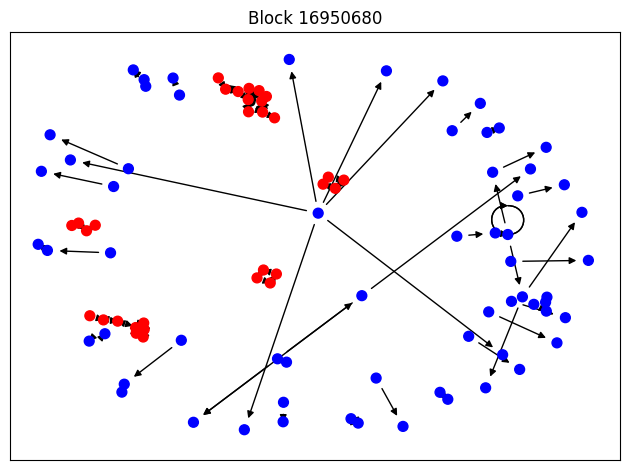

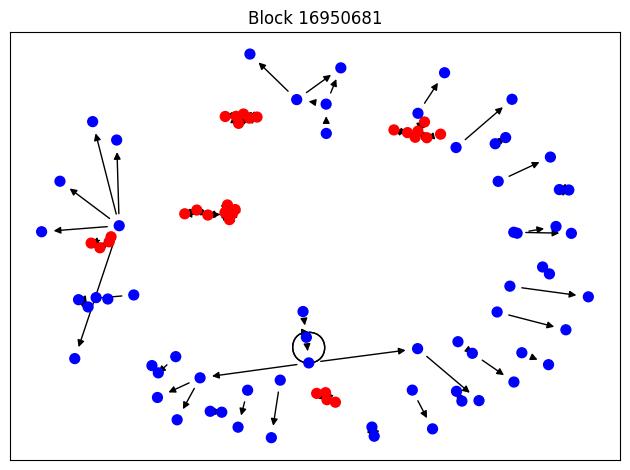

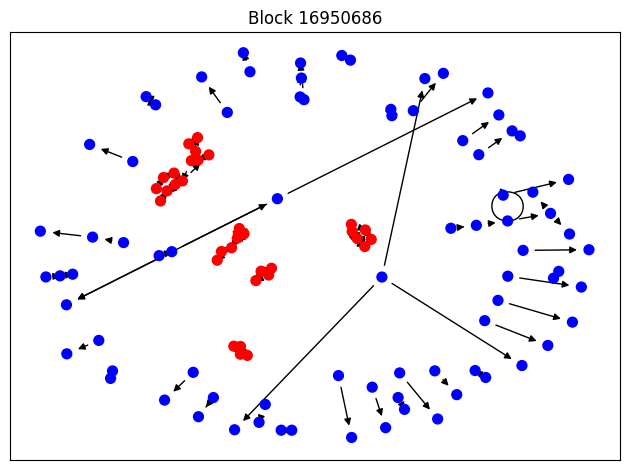

In [116]:
for block, (G, _) in dynamic_graphs.items():
    plot_graph(G, block)

In [107]:
for block, (G, _) in dynamic_graphs.items():
    metrics = compute_graph_metrics(G)
    pprint(metrics)

{'average_degree': 1.9407407407407407,
 'clustering_coefficient': 0.10229276895943563,
 'degree_distribution': {1: 60, 2: 61, 3: 5, 4: 4, 5: 1, 8: 1, 9: 2, 18: 1},
 'density': 0.007241569928137092,
 'largest_component_size': 33,
 'num_isolated_nodes': 0}
{'average_degree': 1.9615384615384615,
 'clustering_coefficient': 0.11693376068376068,
 'degree_distribution': {1: 52, 2: 37, 3: 5, 4: 5, 5: 1, 8: 1, 9: 2, 12: 1},
 'density': 0.009522031366691561,
 'largest_component_size': 15,
 'num_isolated_nodes': 0}
{'average_degree': 2.04,
 'clustering_coefficient': 0.078,
 'degree_distribution': {1: 48, 2: 37, 3: 5, 4: 5, 5: 1, 9: 3, 15: 1},
 'density': 0.010303030303030303,
 'largest_component_size': 18,
 'num_isolated_nodes': 0}
{'average_degree': 1.9574468085106382,
 'clustering_coefficient': 0.08297872340425531,
 'degree_distribution': {1: 47, 2: 33, 3: 5, 4: 4, 5: 1, 6: 1, 9: 2, 11: 1},
 'density': 0.01052390757263784,
 'largest_component_size': 11,
 'num_isolated_nodes': 0}
{'average_degre